## Import Libraries

In [1]:
%%capture
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth

## Initializing and Preparing Mistral-7B for LoRA Fine-Tuning

- Loaded the 4-bit quantized **Mistral-7B** model using Unsloth for efficient memory usage.
- Applied **LoRA (Low-Rank Adaptation)** with 16-rank adapters on key projection modules (e.g., `q_proj`, `k_proj`, `v_proj`, etc.).
- Enabled **gradient checkpointing** to further reduce memory during training and used no bias or dropout for optimized LoRA performance.


In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-04-13 09:07:51.475522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744535271.910662      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744535272.031958      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Mistral patching. Transformers: 4.51.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Preparing AliExpress Review-Reply Dataset for Instruction Tuning

- Loaded labeled review dataset containing `reviewContent`, `sentiment`, `categoryLabel`, and `generatedReply` fields.
- Split into training (90%) and testing (10%) sets with index reset for clean processing.
- Applied Alpaca-style prompt formatting to convert each row into a structured instruction-following task suitable for supervised fine-tuning.


In [13]:
import pandas as pd

# Load the CSV file with encoding
df = pd.read_csv("/kaggle/input/final-response-generation-dataset/Final_Labled_AliExpress_reviews_with_generated_replies.csv.csv")

# Keep only the relevant columns
df = df[["reviewContent", "sentiment", "categoryLabel", "generatedReply"]]

# Show the cleaned DataFrame
df.head()


,reviewContent,sentiment,categoryLabel,generatedReply
0,Works rather well does its job and has amazing...,positive,automotive,That's great to hear! Thanks for the detailed ...
1,I really liked I can take out my quiet dog,positive,fashion,That's great to hear! Thanks for the positive ...
2,Order received successfully and faster than ex...,positive,electronics,Thats always great newsthanks for the detail...
3,Very good the league arrived fast thank you th...,positive,automotive,That's a lot of thanks! We are happy the leagu...
4,"Really high-quality bags, buying worth, it als...",positive,fashion,That sounds great! Thanks for the detailed not...


In [19]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)

# Optional: Reset index
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(len(train_df))
print(len(test_df))

11624
1292


In [20]:
EOS_TOKEN = tokenizer.eos_token
# Define the prompt format
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Formatting function adapted for your dataset
def formatting_prompts_func(examples):
    reviews = examples["reviewContent"]
    sentiments = examples["sentiment"]
    categories = examples["categoryLabel"]
    replies = examples["generatedReply"]
    
    texts = []
    for review, sentiment, category, reply in zip(reviews, sentiments, categories, replies):
        instruction = "Generate a helpful and context-aware reply based on the review, sentiment, and category."
        input_text = f"Review: {review}\nSentiment: {sentiment}\nCategory: {category}"
        text = alpaca_prompt.format(instruction, input_text, reply) + EOS_TOKEN
        texts.append(text)
    
    return {"text": texts}


from datasets import load_dataset, Dataset
import pandas as pd

# Convert to Huggingface Dataset
dataset = Dataset.from_pandas(train_df)
dataset = dataset.map(formatting_prompts_func, batched=True)


Map:   0%|          | 0/11624 [00:00<?, ? examples/s]

## Fine-Tuning for Review-Reply Generation Using SFTTrainer

- Used `SFTTrainer` to fine-tune the LoRA-injected Mistral-7B model on formatted instruction-response data.
- Training configured with 3 epochs, batch size 2, and gradient accumulation for stability on limited GPU memory.
- Achieved efficient memory usage with 8-bit optimizer and bf16/fp16 precision handling.


In [21]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs=3,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 50,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/11624 [00:00<?, ? examples/s]

In [22]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.883 GB of memory reserved.


In [23]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 11,624 | Num Epochs = 3 | Total steps = 2,178
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040/7,000,000,000 (0.60% trained)


Step,Training Loss
50,0.664800
100,0.679900
150,0.639900
200,0.665200
250,0.657600
300,0.664300
350,0.642000
400,0.623200
450,0.634600
500,0.638700


In [24]:
trainer_stats

TrainOutput(global_step=2178, training_loss=0.5014643428301571, metrics={'train_runtime': 20899.9094, 'train_samples_per_second': 1.669, 'train_steps_per_second': 0.104, 'total_flos': 2.4599507365291622e+17, 'train_loss': 0.5014643428301571})

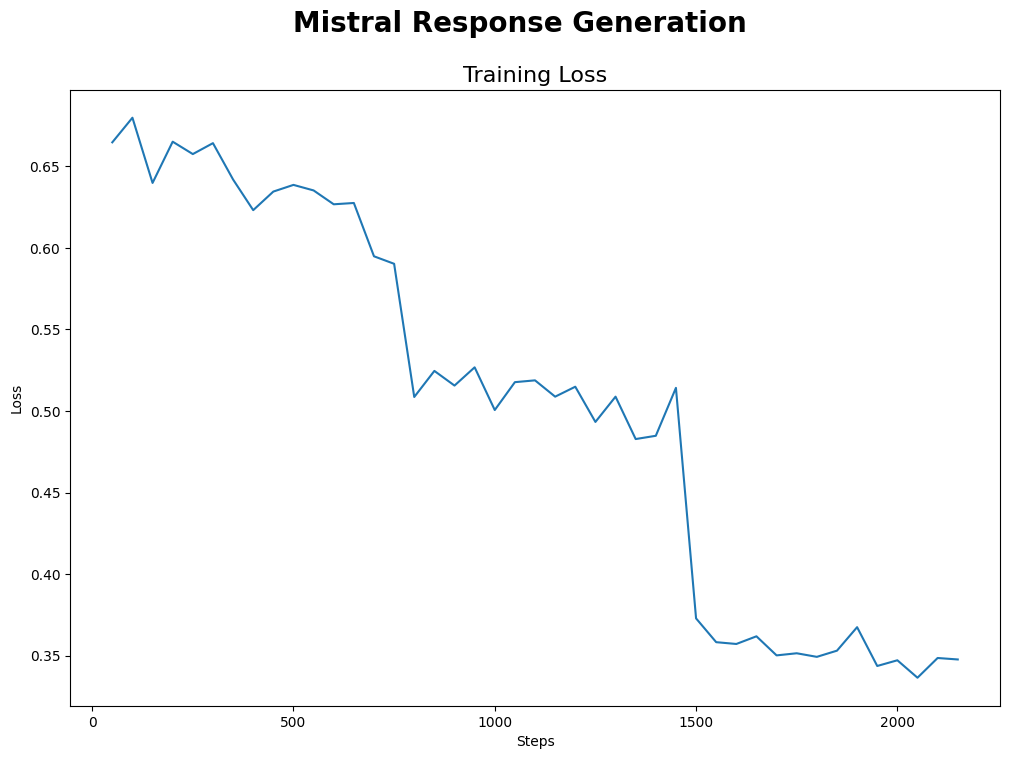

In [ ]:
import matplotlib.pyplot as plt

steps = [log["steps"] for log in trainer.state.log_history if "steps" in log]
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]

# Create the figure with larger size
plt.figure(figsize=(12, 8))  # Adjust the width and height (in inches)

# Plotting the loss curve
plt.plot(steps, losses)

# Adding a heading for the figure
plt.suptitle("Mistral Response Generation", fontsize=20, fontweight='bold')

# Adding the title, axis labels, and displaying the plot
plt.title("Training Loss", fontsize=16)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Loss", fontsize=10)

# Display the plot
plt.show()


In [25]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

20899.9094 seconds used for training.
348.33 minutes used for training.
Peak reserved memory = 6.883 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 46.693 %.
Peak reserved memory for training % of max memory = 0.0 %.


## Push to Hugging Face for Saving the Model Online

In [ ]:
model.push_to_hub("AbuSalehMd/Review_Response_Generation_Mistral_7B_FineTuned", token = "hf_XXXXX") # Online saving

README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/AbuSalehMd/Review_Response_Generation_Mistral_7B_FineTuned


## Sample Inference from Fine-Tuned Reply Generation Model

- Used the trained Mistral-7B model to generate a response based on a single review input from the test set.
- Prompt formatted using Alpaca-style instruction with review, sentiment, and category as context.
- Two decoding methods shown: direct `decode()` and live streaming via `TextStreamer`.


In [28]:
sample = test_df.iloc[0]
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Generate a helpful and context-aware reply based on the review, sentiment, and category.",  # instruction
        f"Review: {sample['reviewContent']}\nSentiment: {sample['sentiment']}\nCategory: {sample['categoryLabel']}",  # input
        "" 
    )
], return_tensors = "pt").to("cuda")
# Generate output
outputs = model.generate(**inputs, max_new_tokens=128, use_cache=True)

# Decode the response
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Extract only the generated reply (after "### Response:")
if "### Response:" in decoded_output:
    reply = decoded_output.split("### Response:")[-1].strip()
else:
    reply = decoded_output.strip()

print(reply)



Thank you for your feedback! We are glad the material and performance impressed you. Your comments are appreciated.


In [29]:
# alpaca_prompt = Copied from above
sample = test_df.iloc[0]
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Generate a helpful and context-aware reply based on the review, sentiment, and category.",  # instruction
        f"Review: {sample['reviewContent']}\nSentiment: {sample['sentiment']}\nCategory: {sample['categoryLabel']}",  # input
        "" 
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Generate a helpful and context-aware reply based on the review, sentiment, and category.

### Input:
Review: The material is sclo, timid, the power of blessing good.
Sentiment: positive
Category: home

### Response:
Thank you for your feedback! We are glad the material and performance impressed you. Your comments are appreciated.</s>


# Evaluation

## Generating Replies for Evaluation

- Iterated over all test samples to generate replies using the fine-tuned model with Alpaca-style prompts.
- Tokenized inputs, generated predictions using `.generate()`, and extracted only the reply part.
- Final output saved as `model_outputs.csv`, containing both reference and predicted replies for metric evaluation.


In [30]:
import pandas as pd
from tqdm import tqdm
import torch

# Copy the test dataset
df = test_df.copy()

# Enable fast inference mode
FastLanguageModel.for_inference(model)

# Prepare storage
generated_replies = []

# Loop through test samples with a progress bar
for idx in tqdm(range(len(df)), desc="Generating replies"):
    sample = df.iloc[idx]
    
    # Create prompt in Alpaca format
    prompt = alpaca_prompt.format(
        "Generate a helpful and context-aware reply based on the review, sentiment, and category.",
        f"Review: {sample['reviewContent']}\nSentiment: {sample['sentiment']}\nCategory: {sample['categoryLabel']}",
        ""
    )
    
    # Tokenize and move to GPU
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    
    # Generate the reply
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=128, use_cache=True)
    
    # Decode the output
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract only the generated reply
    if "### Response:" in decoded:
        reply = decoded.split("### Response:")[-1].strip()
    else:
        reply = decoded.strip()
    
    # Append to list
    generated_replies.append(reply)

# Build final evaluation dataframe
eval_df = pd.DataFrame({
    "review": df["reviewContent"],
    "sentiment": df["sentiment"],
    "category": df["categoryLabel"],
    "reference": df["generatedReply"],  # This is the true reply from original dataset
    "prediction": generated_replies     # This is what your model just generated
})

# Save to CSV
eval_df.to_csv("model_outputs.csv", index=False)

# Display a sample
eval_df.head()


Generating replies: 100%|██████████| 1292/1292 [44:19<00:00,  2.06s/it]


,review,sentiment,category,reference,prediction
0,"The material is sclo, timid, the power of bles...",positive,home,Thank you for your feedback! We are glad the m...,Thank you for your feedback! We are glad the m...
1,Much better than I imagined. I recommend it to...,positive,automotive,That's great to hear! Thanks for the glowing r...,That's always great newsthanks for the glowin...
2,Delivery arrived quickly. Product as described...,positive,electronics,That's always great newsthanks for the shout-...,That's always great newsthanks for the detail...
3,Unfortunately. You can hardly hear anything.,negative,electronics,We apologize for the inconvenience caused by t...,We apologize for the poor sound quality. That ...
4,The video quality is not exceptional and the c...,negative,fashion,Thank you for your honest feedback! We appreci...,Thank you for your honest feedback! We appreci...


## Evaluation Metrics for Reply Generation

- Used **ROUGE**, **METEOR**, and **BERTScore** to evaluate the model-generated replies against reference responses.
- Ensured proper tokenization and NLTK setup for METEOR scoring.

### Results Summary:
- **ROUGE-1**: 0.7559
- **ROUGE-L**: 0.7208
- **METEOR**: 0.7296
- **BERTScore (F1)**: 0.9569


In [31]:
!pip install evaluate bert-score nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00


In [32]:
import pandas as pd
import numpy as np
import evaluate
import nltk

# Download required NLTK data for METEOR
nltk.download('wordnet')
nltk.download('punkt')
# Unzip the wordnet.zip file without interactive prompts
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!unzip -o /usr/share/nltk_data/corpora/punkt.zip -d /usr/share/nltk_data/corpora/


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  

[nltk_data]   Package punkt is already up-to-date!



  inflating: /usr/share/nltk_data/corpora/wordnet/data.noun  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.noun  
  inflating: /usr/share/nltk_data/corpora/wordnet/adj.exc  
unzip:  cannot find or open /usr/share/nltk_data/corpora/punkt.zip, /usr/share/nltk_data/corpora/punkt.zip.zip or /usr/share/nltk_data/corpora/punkt.zip.ZIP.


In [34]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=610c75d437a967f2e76f119a77d2eee2d806c727e5b742817c783846d6a7ccdc
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [36]:


# Load evaluation metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

# Load your fine-tuned model output CSV
# CSV must have columns: 'reference' and 'prediction'
df = pd.read_csv("/kaggle/working/model_outputs.csv")  # Replace with your actual file path
#df=eval_df.copy()
references = df["reference"].astype(str).tolist()
predictions = df["prediction"].astype(str).tolist()

# Compute ROUGE
rouge_scores = rouge.compute(predictions=predictions, references=references, use_stemmer=True)
print("ROUGE-1:", round(rouge_scores["rouge1"], 4))
print("ROUGE-L:", round(rouge_scores["rougeL"], 4))

# Compute METEOR
meteor_score = meteor.compute(predictions=predictions, references=references)
print("METEOR:", round(meteor_score["meteor"], 4))

# Compute BERTScore (F1 average)
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
avg_bertscore_f1 = np.mean(bertscore_result["f1"])
print("BERTScore (F1):", round(avg_bertscore_f1, 4))


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


ROUGE-1: 0.7559
ROUGE-L: 0.7208
METEOR: 0.7296


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore (F1): 0.9569
